# Text To Image Generator

In [42]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

> Text Embedding

In [43]:
# Large pre-trained text embedding model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Example text
text = ["This is a cat", "A beautiful landscape"]

embeddings = embed(text)
print(embeddings)


tf.Tensor(
[[ 0.00267857  0.00618565  0.02630746 ... -0.01753683  0.030954
   0.05257894]
 [-0.02385699 -0.03534554  0.0433051  ...  0.01880139  0.00070179
  -0.00745303]], shape=(2, 512), dtype=float32)


In [23]:
# Alternative small pre-trained text embedding model

# embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50/2")

# Example
# text = ["Hello world", "TensorFlow is great"]

# embeddings = embed(text)
# print(embeddings)



>Loading mnist data set

In [45]:
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train / 127.5 - 1.0  # Normalize to [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)


> Building Generator 

In [46]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(256, input_dim=100),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.8),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.8),
        layers.Dense(1024),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.8),
        layers.Dense(28 * 28 * 1, activation='tanh'),
        layers.Reshape((28, 28, 1))
    ])
    return model

generator = build_generator()

In [40]:
# generator.summary()

>Build Discriminator

In [47]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


>Combine Models

In [48]:
def build_combined(generator, discriminator):
    discriminator.trainable = False
    model = tf.keras.Sequential([generator, discriminator])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

combined = build_combined(generator, discriminator)

>Training Function

In [51]:
def train(generator, discriminator, combined, epochs=100, batch_size=128, save_interval=1000):
    half_batch = int(batch_size / 2)

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1] * batch_size)

        g_loss = combined.train_on_batch(noise, valid_y)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}] [G loss: {g_loss}]")
            

> Start Training

In [52]:
train(generator, discriminator, combined)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
0 [D loss: 3.984727144241333] [G loss: [array(3.987189, dtype=float32), array(3.987189, dtype=float32), array(0.17111838, dtype=float32)]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━

>Generate Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


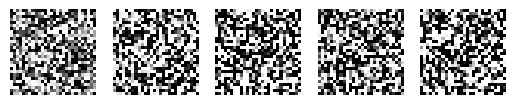

In [56]:
import matplotlib.pyplot as plt

def generate_images(generator, num_images=5):
    noise = np.random.normal(0, 1, (num_images, 100))
    gen_imgs = generator.predict(noise)

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(gen_imgs[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

generate_images(generator)


>Text Encoder

In [65]:
text1 = ["This is a cat"]

text_embeddings = embed(text1)

>Modify Generator for Conditional Inputs

In [66]:
def build_conditional_generator(text_embedding_dim, noise_dim):
    model = tf.keras.Sequential([
        layers.Input(shape=(text_embedding_dim + noise_dim,)),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.8),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.8),
        layers.Dense(1024),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.8),
        layers.Dense(28 * 28 * 1, activation='tanh'),
        layers.Reshape((28, 28, 1))
    ])
    return model

text_embedding_dim = 512  # Example dimension from Universal Sentence Encoder
noise_dim = 100
generator = build_conditional_generator(text_embedding_dim, noise_dim)
# generator.summary()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


> Modify Discriminator for Conditional Inputs

In [68]:
def build_conditional_discriminator(text_embedding_dim):
    img_input = layers.Input(shape=(28, 28, 1))
    text_input = layers.Input(shape=(text_embedding_dim,))
    
    img_flat = layers.Flatten()(img_input)
    x = layers.concatenate([img_flat, text_input])
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    validity = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[img_input, text_input], outputs=validity)
    return model

discriminator = build_conditional_discriminator(text_embedding_dim)
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

> Combine Models

In [69]:
def build_conditional_combined(generator, discriminator):
    discriminator.trainable = False
    
    noise_input = layers.Input(shape=(noise_dim,))
    text_input = layers.Input(shape=(text_embedding_dim,))
    
    gen_img = generator(layers.concatenate([noise_input, text_input]))
    validity = discriminator([gen_img, text_input])
    
    model = tf.keras.Model(inputs=[noise_input, text_input], outputs=validity)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

combined = build_conditional_combined(generator, discriminator)

> Train the Conditional GAN

In [73]:
def train_conditional_gan(generator, discriminator, combined, text_embeddings, epochs=100, batch_size=128, save_interval=1000):
    half_batch = int(batch_size / 2)

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        texts = np.random.choice(text_embeddings, half_batch)  # Example for text embeddings

        noise = np.random.normal(0, 1, (half_batch, noise_dim))
        gen_imgs = generator.predict(np.concatenate([noise, texts], axis=1))

        d_loss_real = discriminator.train_on_batch([imgs, texts], np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch([gen_imgs, texts], np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        valid_y = np.array([1] * batch_size)
        text_batch = np.random.choice(text_embeddings, batch_size)  # Example for text embeddings

        g_loss = combined.train_on_batch([noise, text_batch], valid_y)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}] [D accuracy: {d_loss[1]}] [G loss: {g_loss}]")


> Generate Images from Text

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


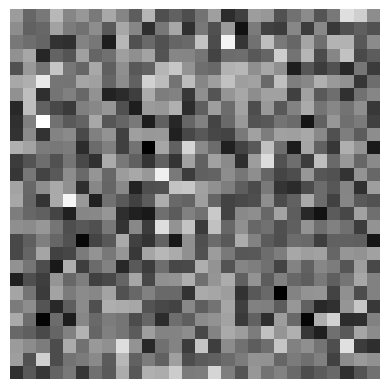

In [74]:
def generate_images_from_text(generator, text, embed):
    text_embeddings = embed([text])
    noise = np.random.normal(0, 1, (1, noise_dim))
    gen_img = generator.predict(np.concatenate([noise, text_embeddings], axis=1))
    
    plt.imshow(gen_img[0, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.show()

generate_images_from_text(generator, "A cute cat", embed)
